# Alameda's isochrones

This notebook generates isochrones around every metro station within Santiago de Chile's project: "Nueva Alameda".

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Load available data

### Load data - pois - Metro stations

In [2]:
metro_dir = "../../../data/external/temporal_todocker/chile/creado/estacionesmetro_nueva_alameda_32719.gpkg"
metro_gdf = gpd.read_file(metro_dir)
metro_gdf = metro_gdf.to_crs("EPSG:4326")

# Show
print(metro_gdf.shape)
metro_gdf.head(2)

(13, 2)


,estacion,geometry
0,Las Rejas,POINT (-70.70630 -33.45744)
1,Ecuador,POINT (-70.69963 -33.45592)


### Load data - Route of interest

<Axes: >

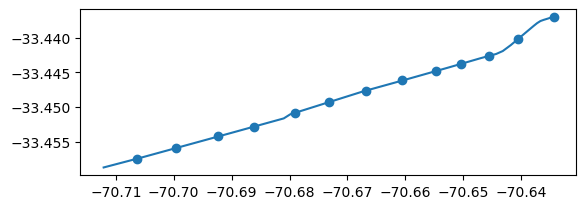

In [3]:
alameda_dir = "../../../data/external/temporal_todocker/chile/compartido/eje_nueva_alameda_32719.gpkg"
alameda_gdf = gpd.read_file(alameda_dir)
alameda_gdf = alameda_gdf.to_crs("EPSG:4326")

# Show plot
fig,ax = plt.subplots()
alameda_gdf.plot(ax=ax)
metro_gdf.plot(ax=ax)

## Process

### Load Network for an area of interest around route of interest (3km buffer)

<Axes: >

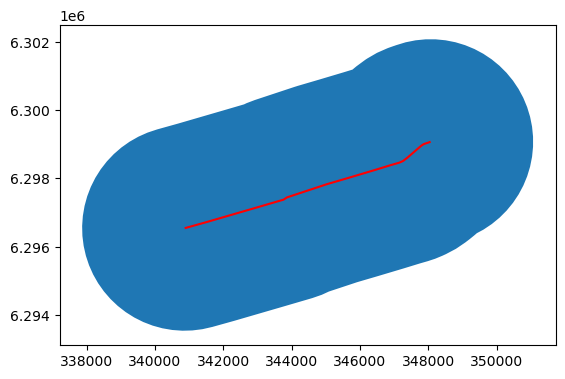

In [4]:
# Create area of interest (aoi)
alameda_projected = alameda_gdf.to_crs("EPSG:32719")
aoi_gdf = alameda_projected.buffer(3000)

# Show plot
fig,ax = plt.subplots()
alameda_projected.plot(ax=ax,zorder=1,color='red')
aoi_gdf.plot(ax=ax,zorder=0)

In [5]:
# Create Network
G, nodes, edges = aup.create_osmnx_network(aoi_gdf, how='from_polygon', network_type='all_private')

Created OSMnx graph from bounding polygon.
Converted OSMnx graph to 23450 nodes and 59584 edges GeoDataFrame.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: access in nodes gdf, has a list in it, the column data was converted to string.
Column: width in nodes gdf, has a list in it, the column data was converted to string.
Column: service in nodes gdf, has a list in it, the column data was converted to string.


In [6]:
# Show nodes
print(nodes.crs)
print(nodes.shape)
nodes.head(2)

EPSG:4326
(23450, 4)


,x,y,street_count,geometry
osmid,,,,
386138,-70.646254,-33.442901,4,POINT (-70.64625 -33.44290)
386139,-70.647249,-33.443129,3,POINT (-70.64725 -33.44313)


In [7]:
# Show edges
print(edges.crs)
print(edges.shape)
edges.head(2)

EPSG:4326
(59584, 15)


osmid  oneway lanes   
u      v           key                            
386138 14805063    0    121815664    True     3  \
       10685413095 0    121815695    True     4   

                                                         name    highway   
u      v           key                                                     
386138 14805063    0                         Enrique Mac Iver  secondary  \
       10685413095 0    Avenida Libertador Bernardo O'Higgins    primary   

                       maxspeed  length   
u      v           key                    
386138 14805063    0         50  18.225  \
       10685413095 0         50  11.518   

                                                                 geometry   
u      v           key                                                      
386138 14805063    0    LINESTRING (-70.64625 -33.44290, -70.64630 -33...  \
       10685413095 0    LINESTRING (-70.64625 -33.44290, -70.64613 -33...   

                       bridge  ref junction tunnel access width service  
u      v           key                                                   
386138 14805063    0      NaN  NaN      NaN    NaN   <NA>  <NA>    <NA>  
       10685413095 0      NaN  NaN      NaN    NaN   <NA>  <NA>    <NA>

<Axes: >

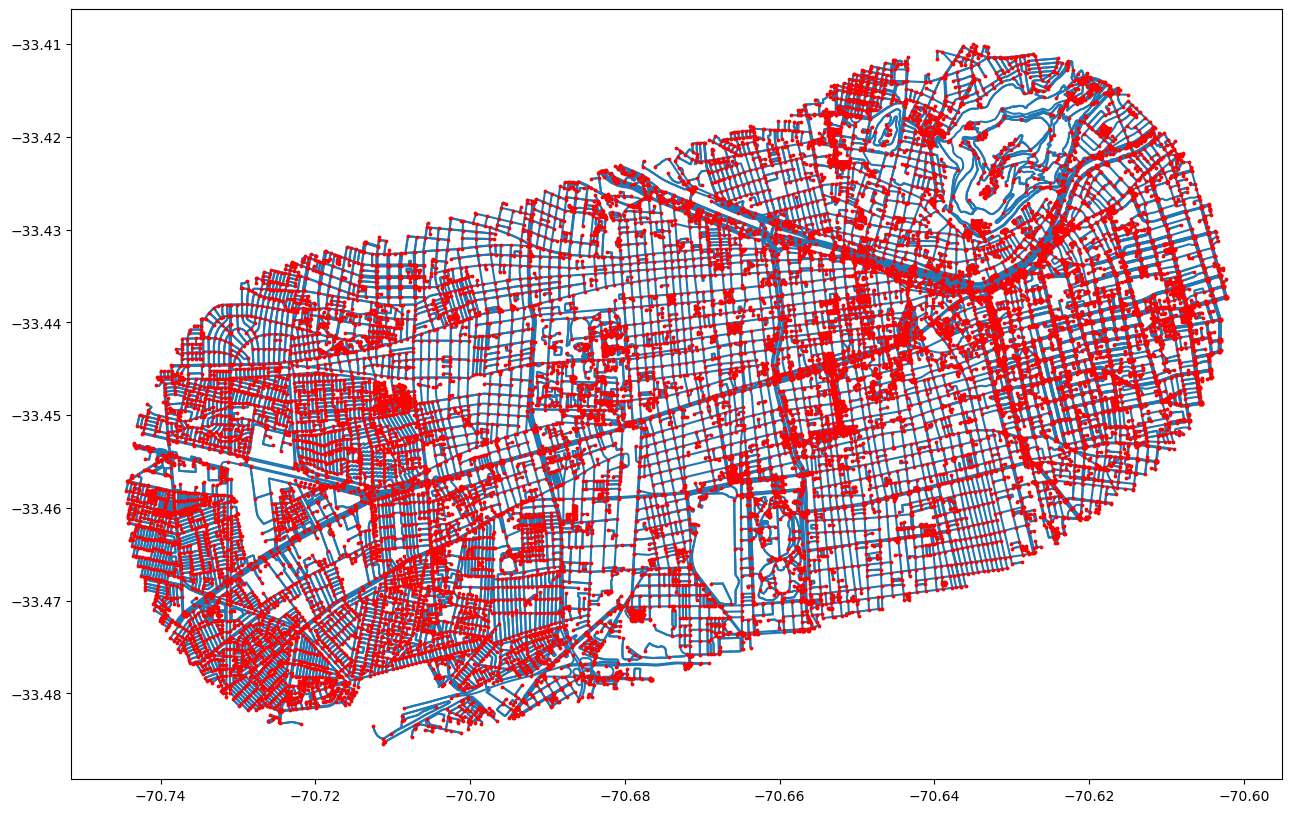

In [8]:
# Show plot
fig,ax = plt.subplots(figsize=(20,10))
nodes.plot(ax=ax,zorder=1,color='red',markersize=3)
edges.plot(ax=ax,zorder=0)

### Assign metro stations to nearest node

In [9]:
nearest = aup.find_nearest(G, nodes, metro_gdf, return_distance= False)

# Show
nearest

,estacion,geometry,osmid
0,Las Rejas,POINT (-70.70630 -33.45744),2352287901
1,Ecuador,POINT (-70.69963 -33.45592),265987895
2,San Alberto Hurtado,POINT (-70.69232 -33.45425),265690468
3,Universidad de Santiago,POINT (-70.68616 -33.45283),3892704962
4,Estación Central,POINT (-70.67900 -33.45083),252528391
5,Unión Latino Americana,POINT (-70.67325 -33.44932),253281854
6,República,POINT (-70.66685 -33.44765),141061506
7,Los Héroes,POINT (-70.66050 -33.44618),5873611211
8,La Moneda,POINT (-70.65478 -33.44484),10724209173
9,Universidad de Chile,POINT (-70.65038 -33.44379),1390401540


In [10]:
#edges.to_file('../../../data/external/temporal_fromjupyter/edges_santiago.gpkg', driver='GPKG')

### Create 15 min isochrones for each of those nodes

In [11]:
# Calculate time assuming a pedestrian speed of 4km/hr
###################################################################################### From function aup.pois_time():
edges = edges.to_crs("EPSG:32719")
prox_measure = 'length'

# 2.1 --------------- FORMAT NETWORK DATA
# Fill NANs with mean times (prevents crash)
edges[prox_measure] = edges.length
# If prox_measure = 'length', calculates time_min assuming walking speed = 4km/hr
if prox_measure == 'length':
    edges['time_min'] = (edges['length']*60)/4000

edges = edges.to_crs("EPSG:4326")
######################################################################################

# Create isochrones
H = G.to_undirected()
nodes_list = list(nearest.osmid.unique())
isochrones_gdf = gpd.GeoDataFrame()
i = 0
for center_node in nodes_list:
    # Calculate isochrone
    sub_G, geometry = aup.calculate_isochrone(H, center_node, trip_time= 15, dist_column='time_min', subgraph=True)
    # Register in GeoDataFrame
    isochrones_gdf.loc[i,'station'] = nearest.loc[nearest.osmid==center_node]['estacion'].unique()[0]
    isochrones_gdf.loc[i,'geometry'] = geometry
    # Next
    i = i+1

# Show
print(isochrones_gdf.shape)
isochrones_gdf.head(3)

(13, 2)


,station,geometry
0,Las Rejas,"POLYGON ((-70.73339 -33.46936, -70.73356 -33.4..."
1,Ecuador,"POLYGON ((-70.70506 -33.46449, -70.71363 -33.4..."
2,San Alberto Hurtado,"POLYGON ((-70.70251 -33.48046, -70.70549 -33.4..."


<Axes: >

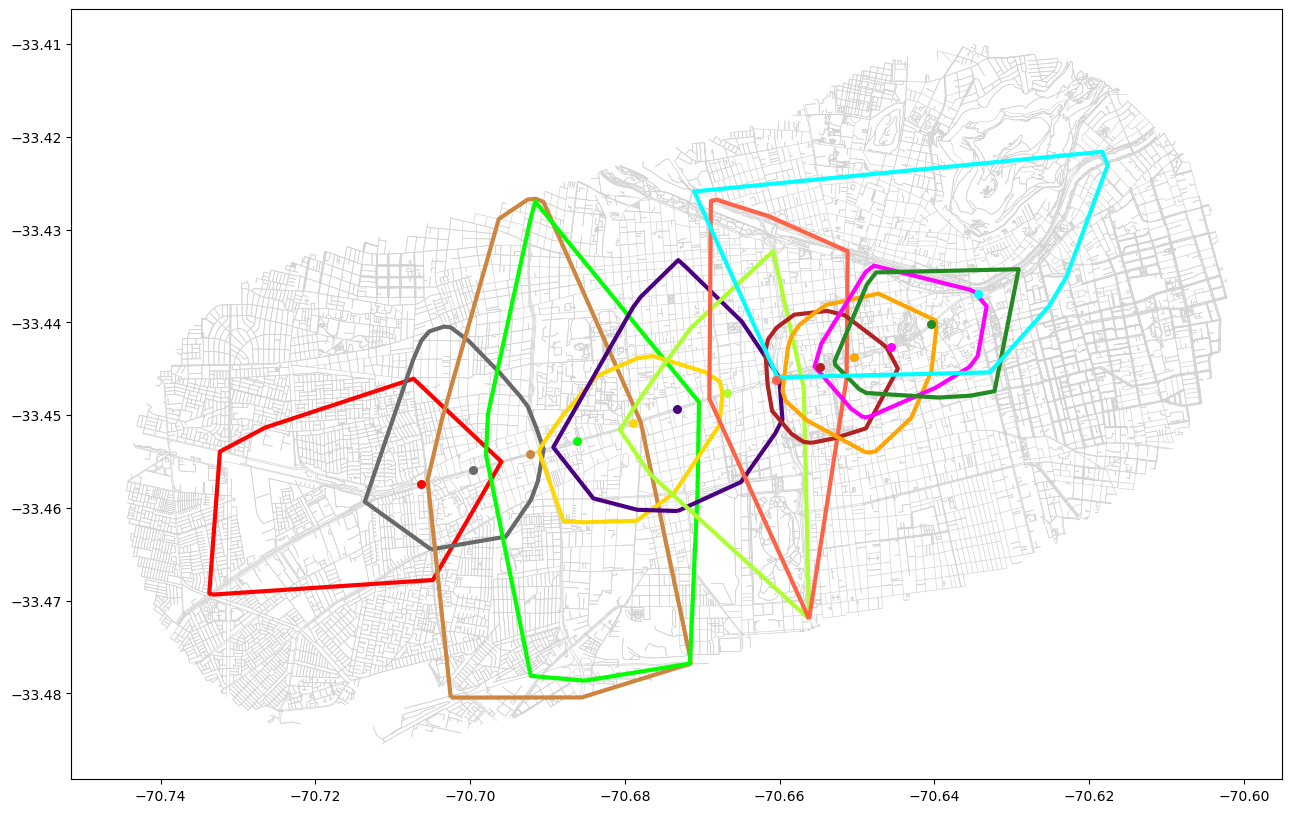

In [12]:
# Show plot
fig,ax = plt.subplots(figsize=(20,10))

c = 0
colors = ['red','dimgray','peru','lime','gold','indigo','greenyellow','tomato','firebrick','orange','magenta','forestgreen','cyan']

for station in isochrones_gdf.station.unique():
    metro_gdf.loc[metro_gdf.estacion == station].plot(ax=ax,zorder=2,color=colors[c],markersize=30)
    isochrones_gdf.loc[isochrones_gdf.station == station].plot(ax=ax,zorder=1,facecolor='None',edgecolor=colors[c],linewidth=3)
    c = c+1

edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')

## Tests

In [29]:
import networkx as nx

<Axes: >

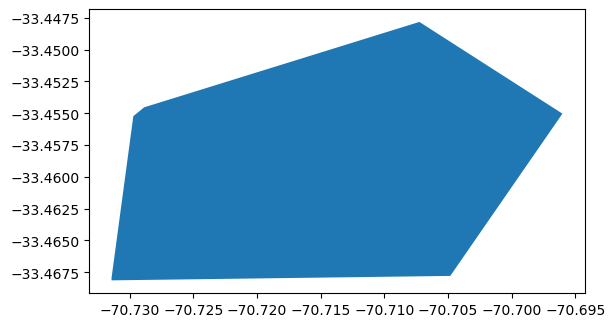

In [24]:
isochrones_gdf_test = gpd.GeoDataFrame()
center_node = nodes_list[0]
geometry = aup.calculate_isochrone(G, center_node, trip_time= 15, dist_column='time_min', subgraph=False)
isochrones_gdf_test.loc[i,'geometry'] = geometry
isochrones_gdf_test.plot()

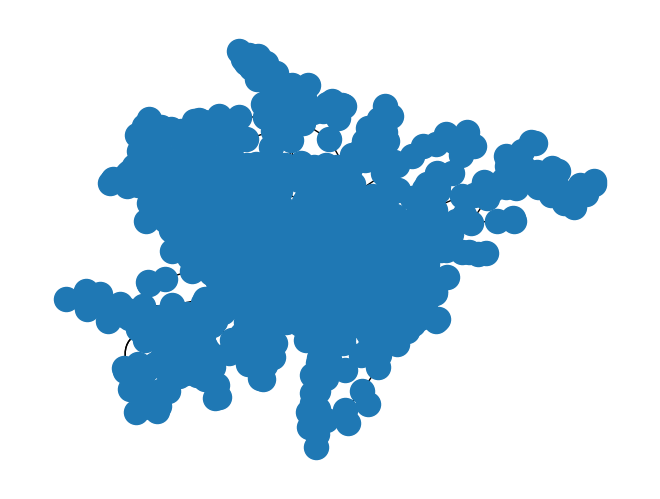

In [38]:
sub_G = nx.ego_graph(H, center_node, radius=15, distance='time_min',center=True,undirected=True)
nx.draw(sub_G, with_labels=False)
plt.show()

<Axes: >

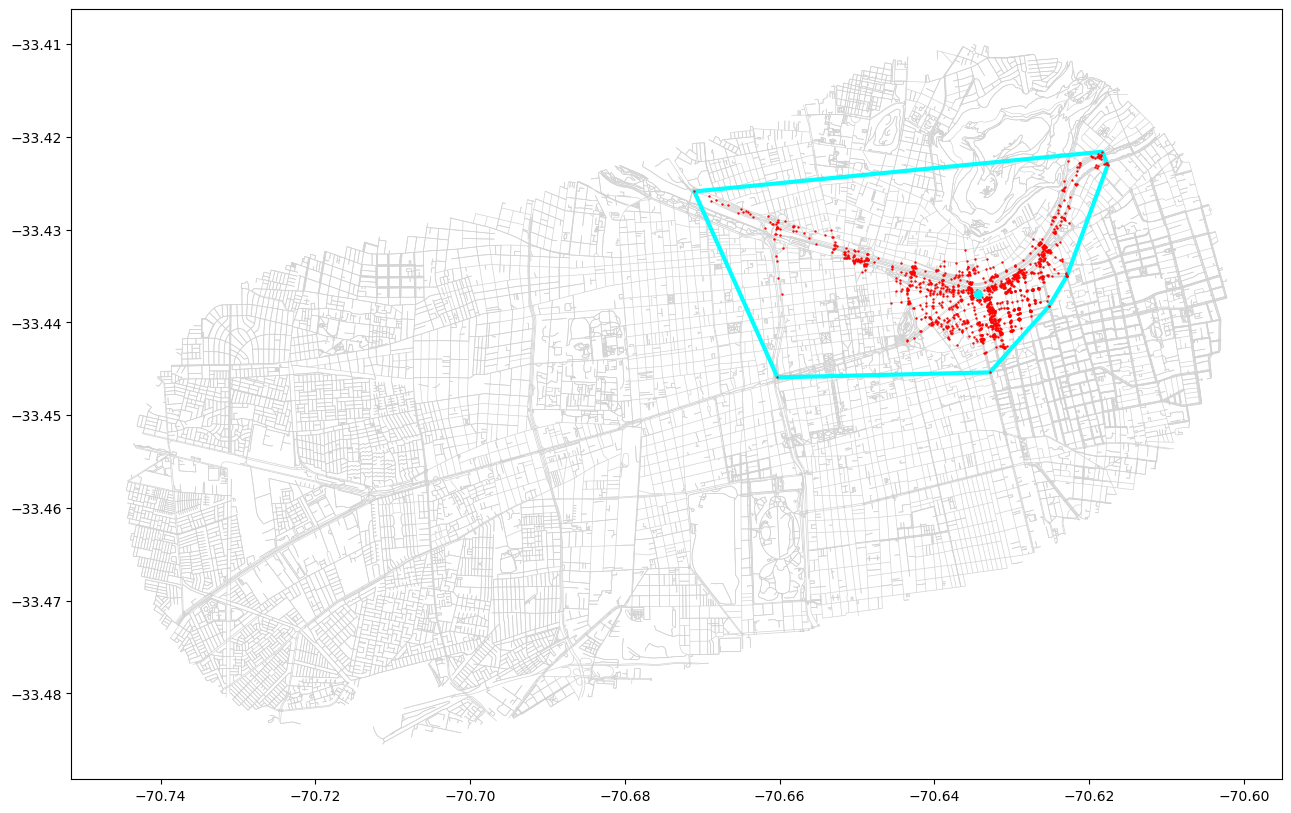

In [13]:
# Get nodes list from subGraph
sub_nodes_lst = list(sub_G.nodes())

# Find those nodes in original nodes gdf
nodes_loc = nodes.copy()
nodes_loc.reset_index(inplace=True)
nodes_loc['keep'] = 0
idx = nodes_loc.osmid.isin(sub_nodes_lst)
nodes_loc.loc[idx,'keep'] = 1
nodes_loc = nodes_loc.loc[nodes_loc.keep==1]

# Show plot
fig,ax = plt.subplots(figsize=(20,10))
metro_gdf.loc[metro_gdf.estacion == 'Baquedano'].plot(ax=ax,zorder=2,color='cyan',markersize=30)
isochrones_gdf.loc[isochrones_gdf.station == 'Baquedano'].plot(ax=ax,zorder=1,facecolor='None',edgecolor='cyan',linewidth=3)
nodes_loc.plot(ax=ax,c='red',markersize=0.5)
edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')

<Axes: >

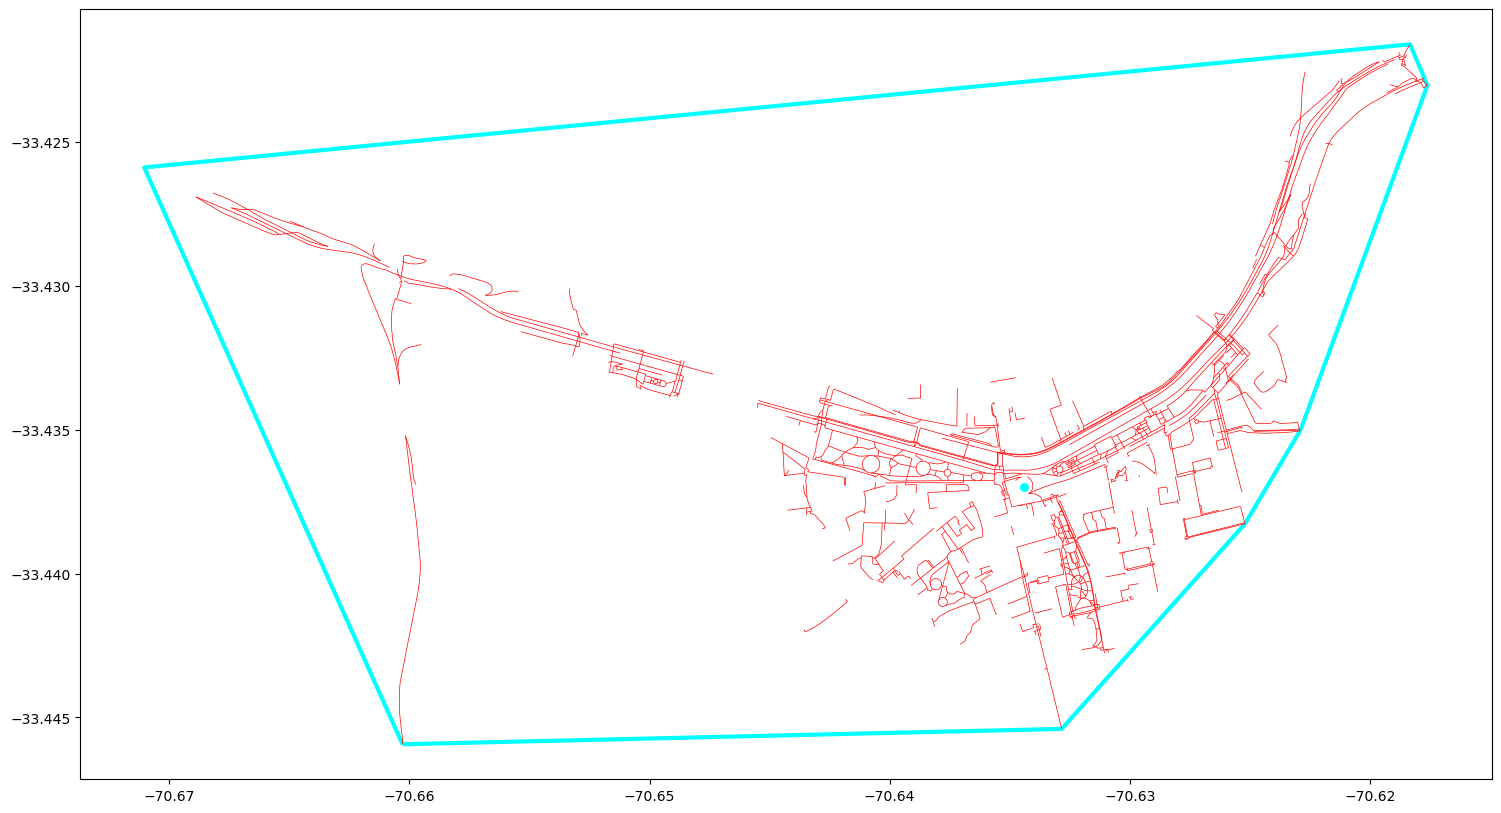

In [14]:
# Get edges list from subGraph
sub_edges_lst = list(sub_G.edges())

# Find those edges in original edges gdf
edges_loc = edges.copy()
edges_loc.reset_index(inplace=True)
edges_loc['keep'] = 0
for current_edge in sub_edges_lst:
    edge_u = current_edge[0]
    edge_v = current_edge[1]
    idx = (edges_loc.u == edge_u) & (edges_loc.v == edge_v)
    edges_loc.loc[idx,'keep'] = 1
edges_loc = edges_loc.loc[edges_loc.keep==1]

# Show plot
fig,ax = plt.subplots(figsize=(20,10))
metro_gdf.loc[metro_gdf.estacion == 'Baquedano'].plot(ax=ax,zorder=2,color='cyan',markersize=30)
isochrones_gdf.loc[isochrones_gdf.station == 'Baquedano'].plot(ax=ax,zorder=1,facecolor='None',edgecolor='cyan',linewidth=3)
edges_loc.plot(ax=ax,zorder=1,edgecolor='red',linewidth=0.5)
#edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')